## Load Dataset

In [1]:
!git clone https://github.com/rekalantar/LiverSegmentation
data_path = '/content/LiverSegmentation/dataset'

Cloning into 'LiverSegmentation'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 118 (delta 21), reused 27 (delta 6), pack-reused 65
Receiving objects: 100% (118/118), 677.26 MiB | 31.10 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Updating files: 100% (48/48), done.


In [2]:
import os
import io
import random
import nibabel
import numpy as np
from glob import glob
import nibabel as nib
import tensorflow as tf
from nibabel import load
import matplotlib.pyplot as plt
from keras.utils import Sequence
from IPython.display import Image, display
from skimage.exposure import rescale_intensity
from skimage.segmentation import mark_boundaries
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

## Define Generator

In [3]:
class NiiDataGenerator(tf.keras.utils.Sequence):
  def __init__(self, image_filenames, mask_filenames, batch_size, image_size):
    self.image_filenames = image_filenames
    self.mask_filenames = mask_filenames
    self.batch_size = batch_size
    self.image_size = image_size

  def __len__(self):
    return int(np.ceil(len(self.image_filenames)/ float(self.batch_size)))

  def __getitem__(self, idx):
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.mask_filenames[idx * self.batch_size : (idx+1) * self.batch_size]

    x = np.zeros((self.batch_size, *self.image_size, 1))
    y = np.zeros((self.batch_size, *self.image_size, 1))

    for i , (image_filename, mask_filename) in enumerate(zip(batch_x, batch_y)):
      image =  nib.load(image_filename)
      mask =  nib.load(mask_filename)

      image_data = image.get_fdata()
      mask_data  = mask.get_fdata()

      slice_index  = random.randint(0, image_data.shape[2] -1)
      x[i, :, :, 0] = image_data[:,:, slice_index]
      y[i, : ,: , 0] = mask_data[:,:, slice_index]

      return x, y


In [5]:
train_images = sorted(glob(os.path.join(data_path,'train','*_orig.nii.gz')))
train_masks = sorted(glob(os.path.join(data_path,'train','*_liver.nii.gz')))

In [6]:
batch_size = 1
image_size = (512, 512)

In [7]:
train_images[0]

'/content/LiverSegmentation/dataset/train/ircad_e01_orig.nii.gz'

In [8]:
train_generator = NiiDataGenerator(train_images[:10],train_masks[:10], batch_size, image_size)

In [9]:
val_generator = NiiDataGenerator(train_images[10:],train_masks[10:], batch_size, image_size)

## Define Unet

In [12]:
def encoder(inputs, filters):
  conv_pool = tf.keras.layers.Conv2D(filters, (3,3) , activation = 'elu', padding = 'same')(inputs)
  conv_pool = tf.keras.layers.Conv2D(filters, (3,3) , activation = 'elu', padding = 'same')(conv_pool)
  return conv_pool

def decoder(inputs, concat_input, filters, transpose_size):
  up = tf.keras.layers.Conv2DTranspose(filters, transpose_size, strides = (2,2), padding = 'same')(inputs)
  up = tf.keras.layers.Concatenate()([up, concat_input])
  up = tf.keras.layers.Conv2D(filters, (3,3), activation = 'elu', padding = 'same')(up)
  up = tf.keras.layers.Conv2D(filters, (3,3), activation = 'elu', padding = 'same')(up)
  return up

def UNet(img_size = (512, 512, 1)):
  inputs = tf.keras.Input(img_size)
  print(inputs.shape)
  print()
  pool_size = (2,2)
  conv1 = encoder(inputs, 32)
  conv_pool1 = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(conv1)
  print("\t Enc. 1 ->", conv_pool1.shape )

  conv2 = encoder(conv_pool1, 64)
  conv_pool2 = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(conv2)
  print("\t\t Enc. 2 ->", conv_pool2.shape )

  conv3 = encoder(conv_pool2, 128)
  conv_pool3 = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(conv3)
  print("\t\t\t Enc. 3 ->", conv_pool3.shape )

  conv4 = encoder(conv_pool3, 256)
  conv_pool4 = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(conv4)
  print("\t\t\t\t Enc. 4 ->", conv_pool4.shape )

  bridge = tf.keras.layers.Conv2D(512, (3,3) , activation = 'elu', padding = 'same')(conv_pool4)
  print("\t\t\t\t\t Bridge Conv ->", bridge.shape )

  # up = tf.keras.layers.Conv2DTranspose(256, (2,2), strides = (2,2), padding = 'same')(bridge)
  # up = tf.keras.layers.Concatenate()([up, conv4])
  # up = tf.keras.layers.Conv2D(256, (3,3), activation = 'elu', padding = 'same')(up)
  # up = tf.keras.layers.Conv2D(256, (3,3), activation = 'elu', padding = 'same')(up)

  up6 = decoder(bridge, conv4, 256 , (2,2))
  print("\t\t\t\t Dec. 4->", up6.shape)

  up7 = decoder(up6, conv3, 128, (2,2))
  print("\t\t\t Dec. 3->", up7.shape)

  up8 = decoder(up7, conv2, 64, (2,2))
  print("\t\t Dec. 2->", up8.shape)

  up9 = decoder(up8, conv1, 32, (2,2))
  print("\t Dec. 1->", up9.shape)

  outputs = tf.keras.layers.Conv2D(1, (1,1), activation = 'sigmoid')(up9)
  print()
  print(outputs.shape)

  model = tf.keras.Model(inputs = [inputs], outputs = [outputs])

  return model

In [13]:
model = UNet()

(None, 512, 512, 1)

	 Enc. 1 -> (None, 256, 256, 32)
		 Enc. 2 -> (None, 128, 128, 64)
			 Enc. 3 -> (None, 64, 64, 128)
				 Enc. 4 -> (None, 32, 32, 256)
					 Bridge Conv -> (None, 32, 32, 512)
				 Dec. 4-> (None, 64, 64, 256)
			 Dec. 3-> (None, 128, 128, 128)
		 Dec. 2-> (None, 256, 256, 64)
	 Dec. 1-> (None, 512, 512, 32)

(None, 512, 512, 1)


## Compile Model

- Dice coefficient is used to monitor metrics

In [14]:
def dice_coef(y_true, y_pred, smooth=1.):
  """
  Dice = (2*|X & Y|)/ (|X|+ |Y|)
        =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
  ref: https://arxiv.org/pdf/1606.04797v1.pdf
  """
  y_true_f = tf.keras.backend.flatten(y_true)
  y_pred_f = tf.keras.backend.flatten(y_pred)
  intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='bce',
              metrics=[dice_coef])

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

## Training Model


In [16]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=300,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[checkpoint])

Epoch 1/300
10/10 [==============================] - ETA: 0s - loss: 1.2141 - dice_coef: 0.1709

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 41s 2s/step - loss: 1.2141 - dice_coef: 0.1709 - val_loss: 0.6322 - val_dice_coef: 0.0049
Epoch 2/300
10/10 [==============================] - 16s 2s/step - loss: 0.2451 - dice_coef: 0.2029 - val_loss: 0.2008 - val_dice_coef: 0.3750
Epoch 3/300
10/10 [==============================] - 17s 2s/step - loss: 0.1894 - dice_coef: 0.2880 - val_loss: 0.1211 - val_dice_coef: 0.3216
Epoch 4/300
10/10 [==============================] - 21s 2s/step - loss: 0.2004 - dice_coef: 0.1592 - val_loss: 0.1101 - val_dice_coef: 0.1810
Epoch 5/300
10/10 [==============================] - 15s 2s/step - loss: 0.1387 - dice_coef: 0.2791 - val_loss: 0.0786 - val_dice_coef: 0.2139
Epoch 6/300
10/10 [==============================] - 13s 1s/step - loss: 0.1481 - dice_coef: 0.3522 - val_loss: 0.1425 - val_dice_coef: 0.4169
Epoch 7/300
10/10 [==============================] - 13s 1s/step - loss: 0.1223 - dice_coef: 0.1825 - val_loss: 0.2764 - val_dice_coef: 0.1558
Epoch 8/300

In [ ]:
# model.save('model')
# !tar cvf unet.tar model

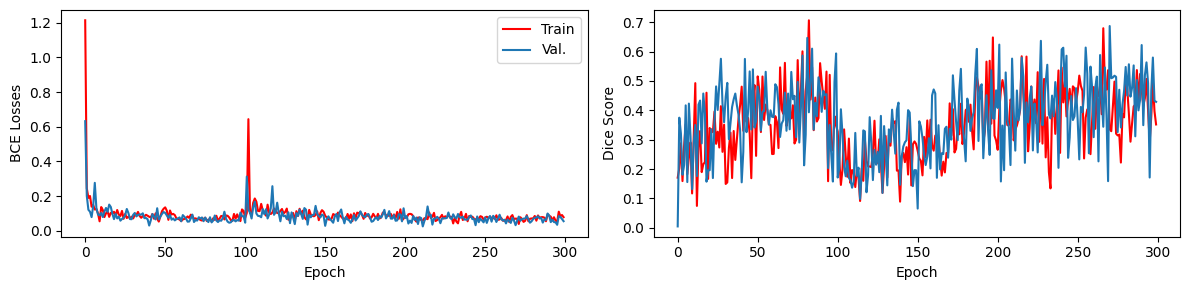

In [17]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'])
plt.ylabel('BCE Losses')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val.'], loc='upper right')
plt.subplot(1,2,2)
plt.plot(history.history['dice_coef'], color='r')
plt.plot(history.history['val_dice_coef'])
plt.ylabel('Dice Score')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

In [18]:
model.load_weights('/content/best_model.h5')

In [19]:
test_images = sorted(glob(os.path.join(data_path, 'test', '*_orig.nii.gz')))
test_masks = sorted(glob(os.path.join(data_path, 'test', '*_liver.nii.gz')))

In [20]:
test_generator = NiiDataGenerator(test_images, test_masks, batch_size, image_size)

test_img, test_mask = next(iter(test_generator))

test_pred = model.predict(test_img)
test_pred_thresh = (test_pred[0,...,0] >= 0.5).astype(np.uint8)

1/1 [==============================] - 0s 417ms/step


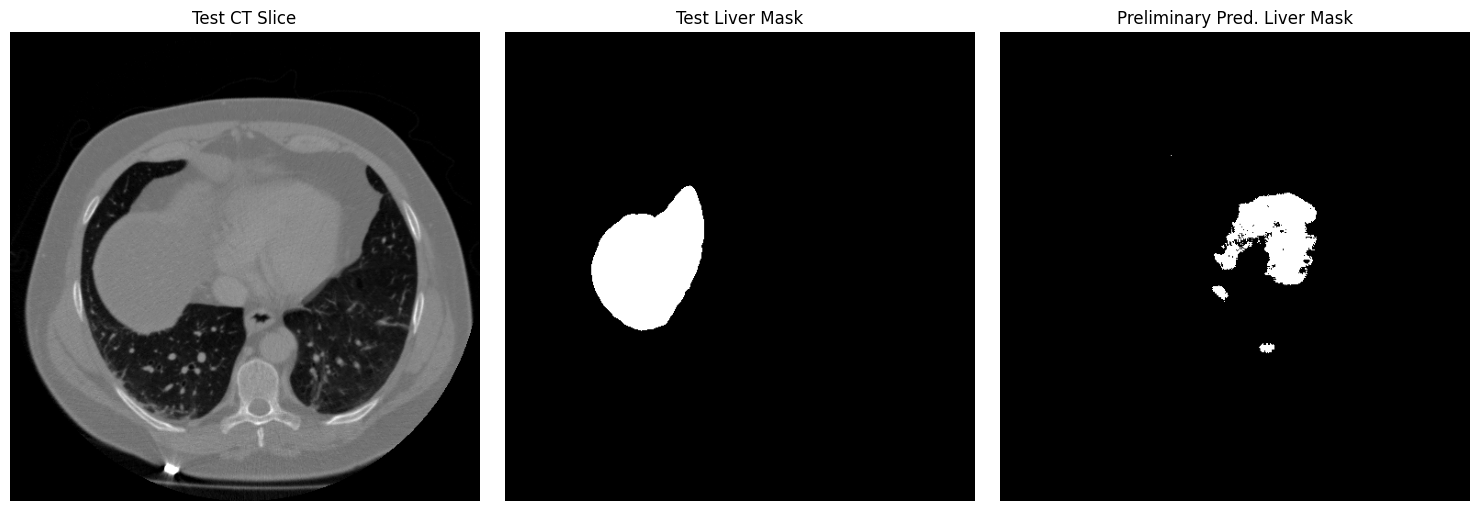

In [21]:
plt.figure(figsize= (15,5))

plt.subplot(1,3,1)
plt.title('Test CT Slice')
plt.imshow(np.rot90(test_img[0,...,0],1), cmap = 'gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Test Liver Mask')
plt.imshow(np.rot90(test_mask[0,...,0], 1), cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Preliminary Pred. Liver Mask')
plt.imshow(np.rot90(test_pred_thresh, 1), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 41ms/step


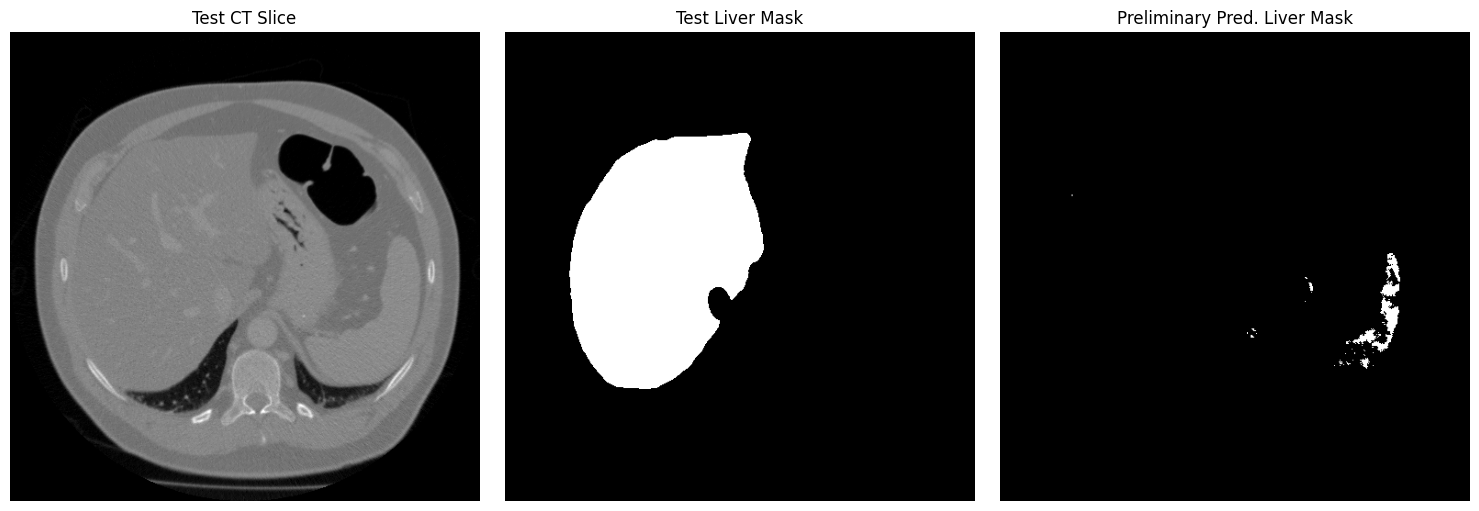


1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

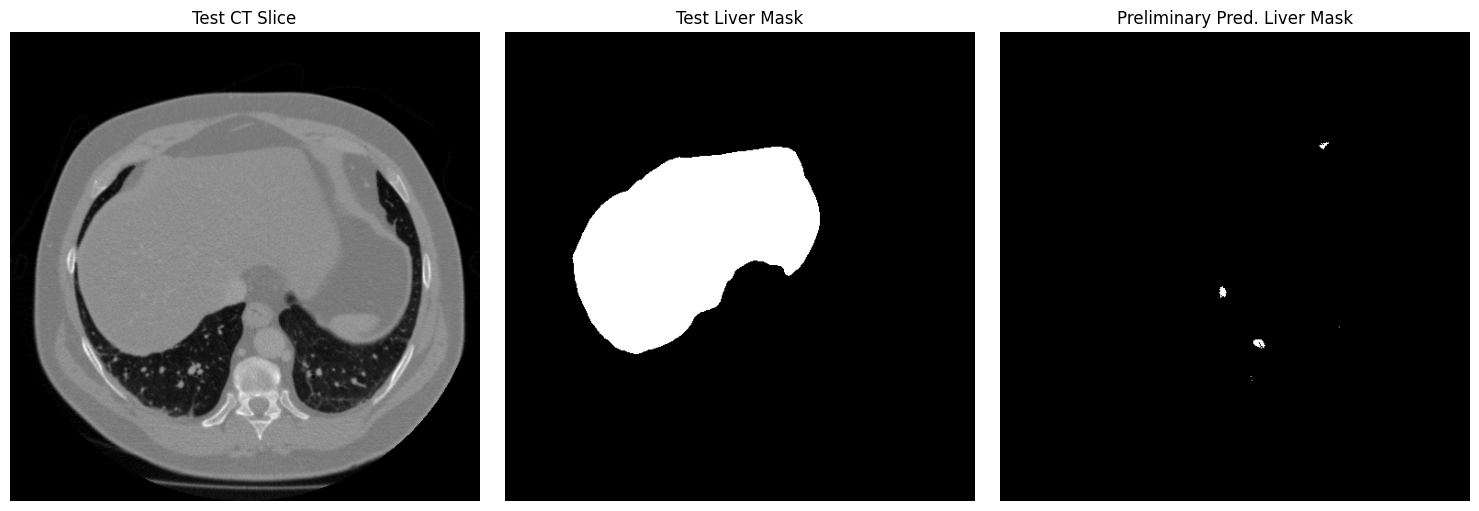


1/1 [==============================] - 0s 43ms/step


<Figure size 640x480 with 0 Axes>

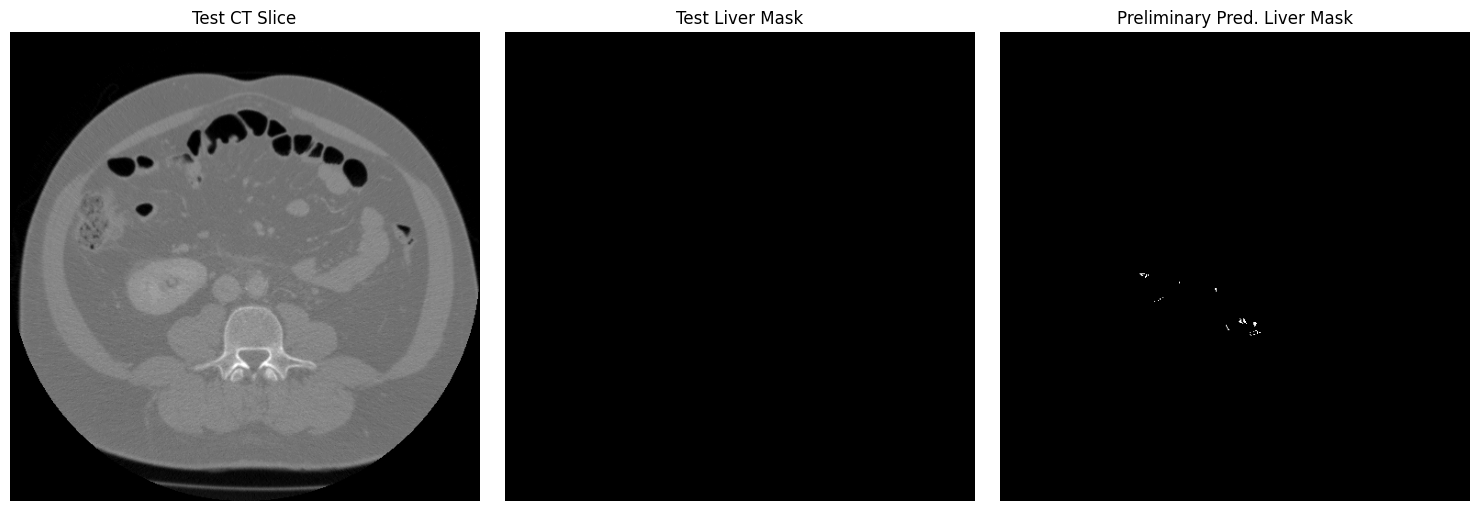


1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

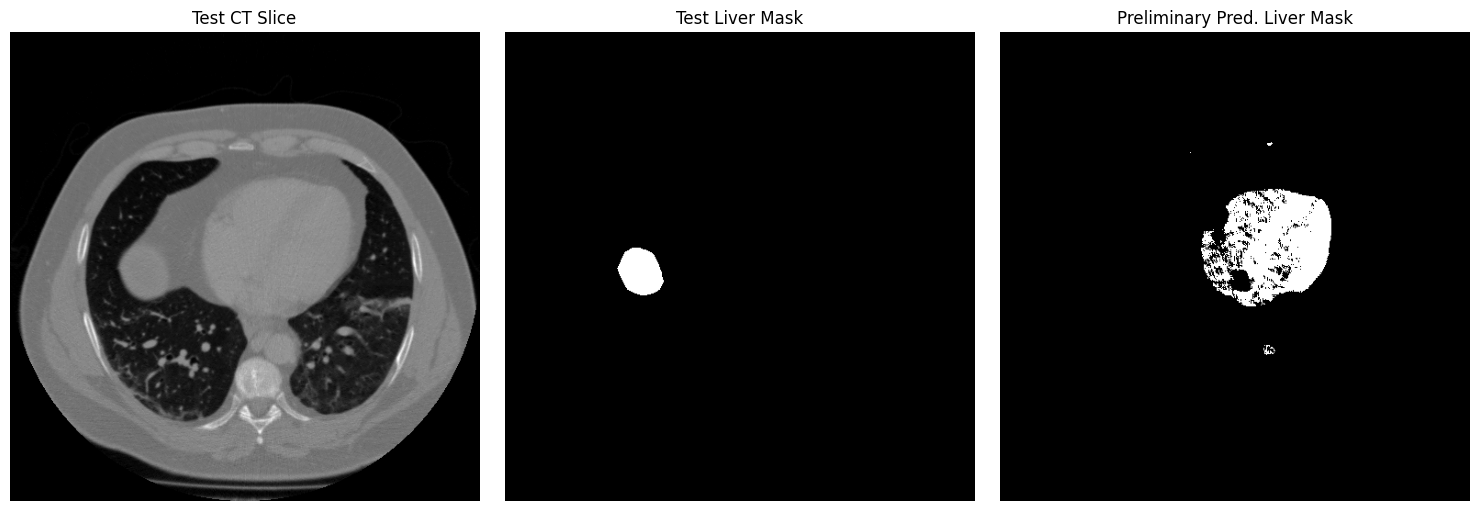


1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

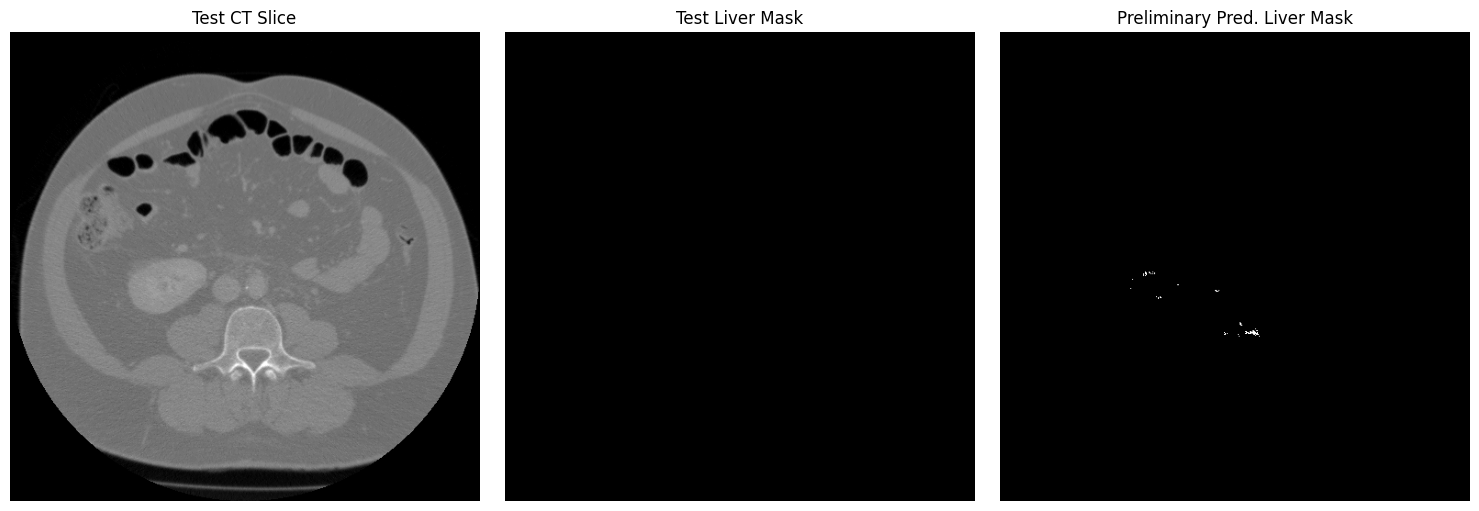

<Figure size 640x480 with 0 Axes>

In [27]:
for _ in range(5):
  test_img, test_mask = next(iter(test_generator))
  test_pred = model.predict(test_img)
  test_pred_thresh = (test_pred[0,...,0] >= 0.5).astype(np.uint8)

  plt.figure(figsize= (15,5))

  plt.subplot(1,3,1)
  plt.title('Test CT Slice')
  plt.imshow(np.rot90(test_img[0,...,0],1), cmap = 'gray')
  plt.axis('off')

  plt.subplot(1,3,2)
  plt.title('Test Liver Mask')
  plt.imshow(np.rot90(test_mask[0,...,0], 1), cmap='gray')
  plt.axis('off')

  plt.subplot(1,3,3)
  plt.title('Preliminary Pred. Liver Mask')
  plt.imshow(np.rot90(test_pred_thresh, 1), cmap='gray')
  plt.axis('off')

  plt.tight_layout()
  plt.show()
  plt.clf()
  print()